
# Noise Robustness Evaluation Notebook

This notebook evaluates the noise robustness of a pitch extraction model trained with the JDC-PitchExtractor repository. It runs additive noise sweeps for several real-world noise types and reports standard melody extraction metrics (RPA, RCA, V/UV accuracy, and octave error rate).



## Environment Setup

Uncomment and run the cell below if the required dependencies are not yet installed in your environment.


In [ ]:
# !pip install soundfile torchaudio torch pyyaml matplotlib librosa pyworld pandas tqdm


## Imports and Global Configuration

The repository root is added to `sys.path` so the notebook can reuse the dataset and model utilities that ship with the project.


In [13]:
import os
import sys
from pathlib import Path
import math
import re
from typing import Any, Dict, List, Tuple

import numpy as np
import pandas as pd
import torch
import torchaudio
import soundfile as sf
import pyworld as pw
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

REPO_ROOT = Path.cwd().resolve().parents[0]
if str(REPO_ROOT) not in sys.path:
    sys.path.append(str(REPO_ROOT))

from meldataset import DEFAULT_MEL_PARAMS
from model import JDCNet

plt.style.use("seaborn-v0_8")
plt.rcParams.update({"figure.figsize": (12, 4), "axes.grid": True})

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda



## User Configuration

Update the configuration dictionary in the next cell with paths specific to your environment:

* `config_path`: Training configuration used for the model (for mel parameters and hop length).
* `checkpoint_path`: Trained model checkpoint to evaluate.
* `eval_list_path`: Text file listing evaluation audio files (one `path|metadata` per line, as used during training).
* `noise_library`: Mapping of noise type to a list of background-noise WAV files. White and pink noise are generated procedurally; for babble, cafe, and HVAC provide representative recordings.
* `output_dir`: Folder used to cache intermediate artifacts.


In [14]:
CONFIG = {
    "config_path": REPO_ROOT / "Configs" / "config.yml",
    "checkpoint_dir": REPO_ROOT / "Checkpoint",
    "checkpoint_path": None,
    "eval_list_path": None,
    "noise_library": {
        "white": [],  # generated procedurally
        "pink": [],   # generated procedurally
        "babble": [REPO_ROOT / "NoiseLibrary" / "babble.wav"],
        "cafe": [REPO_ROOT / "NoiseLibrary" / "cafe.wav"],
        "HVAC": [REPO_ROOT / "NoiseLibrary" / "hvac.wav"],
    },
    "output_dir": REPO_ROOT / "notebooks" / "artifacts",
    "snr_levels": list(range(30, -5, -5)),
    "chunk_size": 192,
    "chunk_overlap": 48,
    "mel_mean": -4.0,
    "mel_std": 4.0,
    "voicing_threshold_hz": 10.0,
}

CONFIG["output_dir"].mkdir(parents=True, exist_ok=True)
CONFIG

{'config_path': PosixPath('/home/zathrus/stts2/PitchExtractor/Configs/config.yml'),
 'checkpoint_dir': PosixPath('/home/zathrus/stts2/PitchExtractor/Checkpoint'),
 'checkpoint_path': None,
 'eval_list_path': None,
 'noise_library': {'white': [],
  'pink': [],
  'babble': [PosixPath('/home/zathrus/stts2/PitchExtractor/NoiseLibrary/babble.wav')],
  'cafe': [PosixPath('/home/zathrus/stts2/PitchExtractor/NoiseLibrary/cafe.wav')],
  'HVAC': [PosixPath('/home/zathrus/stts2/PitchExtractor/NoiseLibrary/hvac.wav')]},
 'output_dir': PosixPath('/home/zathrus/stts2/PitchExtractor/notebooks/artifacts'),
 'snr_levels': [30, 25, 20, 15, 10, 5, 0],
 'chunk_size': 192,
 'chunk_overlap': 48,
 'mel_mean': -4.0,
 'mel_std': 4.0,
 'voicing_threshold_hz': 10.0}


## Helper Utilities

The cell below defines audio utilities, inference helpers, and metric computations used in the evaluation loop. They closely follow the preprocessing steps used during training (`meldataset.MelDataset`).


In [15]:
MEL_PARAMS = DEFAULT_MEL_PARAMS.copy()


def _resolve_relative_path(base: Path, candidate: str | Path) -> Path:
    base_dir = base if base.is_dir() else base.parent
    candidate_path = Path(candidate)
    if candidate_path.is_absolute():
        return candidate_path

    repo_candidate = (REPO_ROOT / candidate_path).resolve()
    config_candidate = (base_dir / candidate_path).resolve()

    if repo_candidate.exists():
        return repo_candidate
    if config_candidate.exists():
        return config_candidate
    return repo_candidate


def _latest_checkpoint(path: Path) -> Path | None:
    if not path.is_dir():
        return None

    def _checkpoint_sort_key(p: Path) -> tuple[int, float]:
        numbers = [int(match) for match in re.findall(r"\d+", p.stem)]
        last_number = numbers[-1] if numbers else -1
        return last_number, p.stat().st_mtime

    candidates = sorted(path.glob("*.pth"), key=_checkpoint_sort_key)
    return candidates[-1] if candidates else None

AUDIO_EXTENSIONS = {".flac", ".m4a", ".mp3", ".ogg", ".wav"}
PROCEDURAL_NOISE_TYPES = {"white", "pink"}
RESOLVED_NOISE_LIBRARY: Dict[str, List[Path]] = {}
MISSING_NOISE_TYPES: Dict[str, List[str]] = {}


def _resolve_noise_candidate(candidate: str | Path) -> Path:
    candidate_path = Path(candidate)
    if candidate_path.is_absolute():
        return candidate_path
    repo_candidate = (REPO_ROOT / candidate_path).resolve()
    config_path = CONFIG.get("config_path")
    if config_path:
        config_base = Path(config_path)
        base_dir = config_base if config_base.is_dir() else config_base.parent
        config_candidate = (base_dir / candidate_path).resolve()
        if config_candidate.exists():
            return config_candidate
    return repo_candidate


def refresh_noise_library(force: bool = False) -> Dict[str, List[Path]]:
    """Resolve configured noise sources to on-disk audio files."""
    global RESOLVED_NOISE_LIBRARY, MISSING_NOISE_TYPES
    if RESOLVED_NOISE_LIBRARY and not force:
        return RESOLVED_NOISE_LIBRARY

    resolved: Dict[str, List[Path]] = {noise_type: [] for noise_type in PROCEDURAL_NOISE_TYPES}
    missing: Dict[str, List[str]] = {}
    for noise_type, entries in CONFIG["noise_library"].items():
        if noise_type in PROCEDURAL_NOISE_TYPES:
            resolved.setdefault(noise_type, [])
            continue

        entry_list = entries if isinstance(entries, (list, tuple, set)) else [entries]
        audio_sources: List[Path] = []
        issues: List[str] = []
        for entry in entry_list:
            if entry is None:
                continue
            entry_str = str(entry).strip()
            if not entry_str:
                continue
            candidate = _resolve_noise_candidate(entry)
            if not candidate.exists():
                issues.append(f"{candidate} (not found)")
                continue
            if candidate.is_dir():
                files = sorted(
                    p for p in candidate.rglob("*") if p.suffix.lower() in AUDIO_EXTENSIONS
                )
                if files:
                    audio_sources.extend(files)
                else:
                    issues.append(f"{candidate} (directory has no supported audio files)")
            elif candidate.is_file():
                if candidate.suffix.lower() in AUDIO_EXTENSIONS:
                    audio_sources.append(candidate)
                else:
                    issues.append(f"{candidate} (unsupported extension)")
            else:
                issues.append(f"{candidate} (not a file or directory)")

        if audio_sources:
            resolved[noise_type] = audio_sources
        else:
            missing[noise_type] = issues or ["No valid sources configured."]

    RESOLVED_NOISE_LIBRARY = resolved
    MISSING_NOISE_TYPES = missing
    if missing:
        print("Warning: unable to locate noise audio for the following types:")
        for noise_type, problems in missing.items():
            print(f"  - {noise_type}:")
            for problem in problems:
                print(f"      {problem}")
        print("Update CONFIG['noise_library'] with valid file or directory paths to enable these sweeps.")
    return RESOLVED_NOISE_LIBRARY



if CONFIG["config_path"].is_file():
    import yaml

    with open(CONFIG["config_path"], "r", encoding="utf-8") as config_file:
        training_config = yaml.safe_load(config_file) or {}

    MEL_PARAMS.update(training_config.get("dataset_params", {}).get("mel_params", {}))
    dataset_sr = training_config.get("dataset_params", {}).get("sr")
    if dataset_sr is not None:
        MEL_PARAMS["sample_rate"] = dataset_sr

    val_data = training_config.get("val_data")
    if val_data:
        CONFIG["eval_list_path"] = _resolve_relative_path(CONFIG["config_path"], val_data)
        if not CONFIG["eval_list_path"].is_file():
            print(f"Warning: evaluation list not found at {CONFIG['eval_list_path']}")
    else:
        print("Warning: validation list not defined in config; set CONFIG['eval_list_path'] manually.")

    log_dir = training_config.get("log_dir")
    if log_dir:
        CONFIG["checkpoint_dir"] = _resolve_relative_path(CONFIG["config_path"], log_dir)
    elif not CONFIG["checkpoint_dir"].is_dir():
        print("Warning: log_dir missing in config and default checkpoint directory does not exist.")

    latest_checkpoint = _latest_checkpoint(CONFIG["checkpoint_dir"])
    if latest_checkpoint is not None:
        CONFIG["checkpoint_path"] = latest_checkpoint
    else:
        print(f"Warning: no checkpoint files found in {CONFIG['checkpoint_dir']}. Set CONFIG['checkpoint_path'] manually.")
else:
    print("Warning: config file not found, falling back to DEFAULT_MEL_PARAMS")

refresh_noise_library(force=True)

TARGET_SAMPLE_RATE = MEL_PARAMS["sample_rate"]
HOP_LENGTH = MEL_PARAMS["hop_length"]
FRAME_PERIOD_MS = HOP_LENGTH * 1000.0 / TARGET_SAMPLE_RATE

mel_transform = torchaudio.transforms.MelSpectrogram(**MEL_PARAMS).to(DEVICE)


def _ensure_mono(audio: np.ndarray) -> np.ndarray:
    if audio.ndim == 1:
        return audio
    return audio.mean(axis=1)


def load_waveform(path: Path, target_sr: int = TARGET_SAMPLE_RATE) -> Tuple[np.ndarray, int]:
    audio, sr = sf.read(str(path), dtype="float32")
    audio = _ensure_mono(audio)
    if sr != target_sr:
        tensor = torch.from_numpy(audio).unsqueeze(0)
        resampled = torchaudio.functional.resample(tensor, sr, target_sr)
        audio = resampled.squeeze(0).cpu().numpy()
        sr = target_sr
    return audio, sr


def compute_reference_f0(audio: np.ndarray, sr: int) -> np.ndarray:
    if audio.size == 0:
        return np.zeros((0,), dtype=np.float32)
    audio64 = audio.astype("double")
    f0, t = pw.harvest(audio64, sr, frame_period=FRAME_PERIOD_MS)
    if np.count_nonzero(f0) < 5:
        f0, t = pw.dio(audio64, sr, frame_period=FRAME_PERIOD_MS)
    refined = pw.stonemask(audio64, f0, t, sr)
    return refined.astype(np.float32)


def waveform_to_mel(audio: np.ndarray) -> torch.Tensor:
    tensor = torch.from_numpy(audio).float().unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        mel = mel_transform(tensor)
    mel = torch.log(mel + 1e-5)
    mel = (mel - CONFIG["mel_mean"]) / CONFIG["mel_std"]
    return mel.squeeze(0)


def predict_f0(model: JDCNet, audio: np.ndarray) -> np.ndarray:
    mel = waveform_to_mel(audio)
    total_frames = mel.shape[-1]
    chunk_size = CONFIG["chunk_size"]
    overlap = CONFIG["chunk_overlap"]
    step = max(chunk_size - overlap, 1)

    preds = []
    for start in range(0, total_frames, step):
        end = min(start + chunk_size, total_frames)
        mel_chunk = mel[:, start:end]
        pad = chunk_size - mel_chunk.shape[-1]
        if pad > 0:
            mel_chunk = torch.nn.functional.pad(mel_chunk, (0, pad))
        mel_chunk = mel_chunk.unsqueeze(0).unsqueeze(0)
        mel_chunk = mel_chunk.transpose(-1, -2)
        with torch.no_grad():
            f0_chunk, _ = model(mel_chunk)
        f0_chunk = f0_chunk.squeeze().detach().cpu().numpy()
        preds.append(f0_chunk[: end - start])
    if preds:
        return np.concatenate(preds)
    return np.zeros((0,), dtype=np.float32)


def voss_mccartney_pink(length: int) -> np.ndarray:
    num_rows = 16
    random_state = np.random.randn(num_rows, length).astype(np.float32)
    cumulative = np.cumsum(random_state, axis=1)
    weighting = 2.0 ** np.arange(num_rows, dtype=np.float32)[:, None]
    pink = (cumulative / weighting).sum(axis=0)
    pink /= np.max(np.abs(pink) + 1e-12)
    return pink.astype(np.float32)


def load_noise_sample(noise_type: str, length: int) -> np.ndarray:
    if noise_type == "white":
        return np.random.randn(length).astype(np.float32)
    if noise_type == "pink":
        return voss_mccartney_pink(length)

    library = RESOLVED_NOISE_LIBRARY.get(noise_type, [])
    if library:
        path = np.random.choice(list(library))
        audio, _ = load_waveform(path, TARGET_SAMPLE_RATE)
        if audio.shape[0] < length:
            reps = math.ceil(length / audio.shape[0])
            audio = np.tile(audio, reps)
        start = np.random.randint(0, max(1, audio.shape[0] - length + 1))
        sample = audio[start:start + length]
        return sample.astype(np.float32)

    missing_details = MISSING_NOISE_TYPES.get(noise_type)
    if missing_details:
        detail_lines = "\n".join(f"  - {detail}" for detail in missing_details)
        message = "\n".join(
            [
                f"No audio files found for noise type '{noise_type}'.",
                detail_lines,
                "Update CONFIG['noise_library'][noise_type] with valid file or directory paths.",
            ]
        )
        raise FileNotFoundError(message)


    raise FileNotFoundError(
        f"No audio files found for noise type '{noise_type}'. "
        "Update CONFIG['noise_library'][noise_type] with valid file or directory paths."
    )


def mix_snr(clean: np.ndarray, noise: np.ndarray, snr_db: float) -> np.ndarray:
    if noise.shape[0] < clean.shape[0]:
        reps = math.ceil(clean.shape[0] / noise.shape[0])
        noise = np.tile(noise, reps)
    noise = noise[: clean.shape[0]]
    clean_rms = np.sqrt(np.mean(clean ** 2) + 1e-12)
    noise_rms = np.sqrt(np.mean(noise ** 2) + 1e-12)
    desired_noise_rms = clean_rms / (10 ** (snr_db / 20))
    scaled_noise = noise * (desired_noise_rms / noise_rms)
    return clean + scaled_noise


def hz_to_cents(f0: np.ndarray) -> np.ndarray:
    cents = np.zeros_like(f0)
    positive = f0 > 0
    cents[positive] = 1200.0 * np.log2(f0[positive] / 55.0)
    return cents


def circular_cents_distance(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    diff = a - b
    diff = np.mod(diff + 600.0, 1200.0) - 600.0
    return diff


def compute_metrics(reference: np.ndarray, prediction: np.ndarray) -> Dict[str, float]:
    length = min(reference.shape[0], prediction.shape[0])
    reference = reference[:length]
    prediction = prediction[:length]

    ref_voiced = reference > 0
    pred_voiced = prediction > CONFIG["voicing_threshold_hz"]

    total_frames = length
    voiced_frames = np.count_nonzero(ref_voiced)

    vuv_accuracy = np.count_nonzero(ref_voiced == pred_voiced) / max(total_frames, 1)

    if voiced_frames == 0:
        return {
            "RPA": float("nan"),
            "RCA": float("nan"),
            "VUV": vuv_accuracy,
            "OctaveError": float("nan"),
        }

    ref_cents = hz_to_cents(reference[ref_voiced])
    pred_cents = hz_to_cents(np.clip(prediction[ref_voiced], a_min=1e-5, a_max=None))

    cents_diff = pred_cents - ref_cents
    rpa_hits = np.abs(cents_diff) <= 50.0

    chroma_diff = circular_cents_distance(pred_cents, ref_cents)
    rca_hits = np.abs(chroma_diff) <= 50.0

    octave_candidates = np.abs(cents_diff) > 50.0
    octave_numbers = np.round(cents_diff / 1200.0)
    octave_errors = octave_candidates & (octave_numbers != 0) & (np.abs(cents_diff - octave_numbers * 1200.0) <= 50.0)

    return {
        "RPA": np.count_nonzero(rpa_hits) / voiced_frames,
        "RCA": np.count_nonzero(rca_hits) / voiced_frames,
        "VUV": vuv_accuracy,
        "OctaveError": np.count_nonzero(octave_errors) / voiced_frames,
    }

DATASET_CACHE: list[dict[str, Any]] | None = None


def prepare_dataset_cache(force: bool = False) -> list[dict[str, Any]]:
    """Load evaluation waveforms and ground-truth f0s, caching results."""
    global DATASET_CACHE
    if DATASET_CACHE is not None and not force:
        return DATASET_CACHE

    if CONFIG["eval_list_path"] is None or not Path(CONFIG["eval_list_path"]).is_file():
        raise FileNotFoundError(f"Evaluation list not found: {CONFIG['eval_list_path']}")

    eval_entries: List[Path] = []
    with open(CONFIG["eval_list_path"], "r", encoding="utf-8") as file:
        for line in file:
            line = line.strip()
            if not line:
                continue
            relative_path = line.split("|")[0]
            path = Path(relative_path)
            if not path.is_absolute():
                path = (CONFIG["eval_list_path"].parent / path).resolve()
            eval_entries.append(path)

    if not eval_entries:
        raise RuntimeError(f"No evaluation files found in {CONFIG['eval_list_path']}")

    cache: list[dict[str, Any]] = []
    for path in tqdm(eval_entries, desc="Preparing evaluation cache"):
        audio, sr = load_waveform(path)
        ref_f0 = compute_reference_f0(audio, sr)
        cache.append(
            {
                "path": path,
                "audio": audio,
                "sample_rate": sr,
                "reference_f0": ref_f0,
            }
        )

    DATASET_CACHE = cache
    print(f"Cached {len(DATASET_CACHE)} evaluation utterances.")
    return DATASET_CACHE


  - babble:
      /home/zathrus/stts2/PitchExtractor/NoiseLibrary/babble.wav (not found)
  - cafe:
      /home/zathrus/stts2/PitchExtractor/NoiseLibrary/cafe.wav (not found)
  - HVAC:
      /home/zathrus/stts2/PitchExtractor/NoiseLibrary/hvac.wav (not found)
Update CONFIG['noise_library'] with valid file or directory paths to enable these sweeps.



## Load Model and Evaluation Set

This cell loads the trained checkpoint, moves the model to the selected device, and prepares the evaluation dataset by caching the clean waveforms and reference F0 tracks generated with WORLD vocoders.


In [16]:
if CONFIG["checkpoint_path"] is None or not Path(CONFIG["checkpoint_path"]).is_file():
    raise FileNotFoundError(f"Checkpoint not found: {CONFIG['checkpoint_path']}")

model = JDCNet(num_class=1)
state = torch.load(CONFIG["checkpoint_path"], map_location="cpu")
model.load_state_dict(state["model"] if "model" in state else state)
model.to(DEVICE)
model.eval()
print(f"Loaded checkpoint from {CONFIG['checkpoint_path']}")

prepare_dataset_cache(force=True)

/home/zathrus/stts2/venv/lib/python3.13/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Loaded checkpoint from /home/zathrus/stts2/PitchExtractor/Checkpoint_base/epoch_00100.pth


Preparing evaluation cache: 100%|█████████████████████████████████████████████████████| 178/178 [01:55<00:00,  1.54it/s]


Cached 178 evaluation utterances.


[{'path': PosixPath('/home/zathrus/stts2/cs/results/final_filtered/wavs/T-0010971.wav'),
  'audio': array([ 0.        ,  0.        ,  0.        , ..., -0.0012207 ,
         -0.00170898, -0.00177002], shape=(109293,), dtype=float32),
  'sample_rate': 24000,
  'reference_f0': array([  0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.


## Noise Robustness Sweep

For each noise type and signal-to-noise ratio (SNR) level, the notebook adds noise to the cached waveforms, runs the model, and aggregates metric scores.


In [17]:

RESULTS = []
noise_types = list(CONFIG["noise_library"].keys())
metrics = ["RPA", "RCA", "VUV", "OctaveError"]

resolved_noise_library = refresh_noise_library(force=True)
available_noise_types: List[str] = []
skipped_noise_types: List[str] = []

for noise_type in noise_types:
    if noise_type in PROCEDURAL_NOISE_TYPES or resolved_noise_library.get(noise_type):
        available_noise_types.append(noise_type)
    else:
        skipped_noise_types.append(noise_type)

if skipped_noise_types:
    skipped = ", ".join(skipped_noise_types)
    print(f"Skipping noise types with no audio sources configured: {skipped}")

if not available_noise_types:
    raise RuntimeError("No noise types with audio sources are configured. Update CONFIG['noise_library'].")

dataset_cache = prepare_dataset_cache()
for noise_type in available_noise_types:
    for snr_db in CONFIG["snr_levels"]:
        metric_totals = {metric: [] for metric in metrics}
        for entry in tqdm(dataset_cache, desc=f"{noise_type} @ {snr_db} dB", leave=False):
            noisy = mix_snr(entry["audio"], load_noise_sample(noise_type, entry["audio"].shape[0]), snr_db)
            prediction = predict_f0(model, noisy)
            metric_values = compute_metrics(entry["reference_f0"], prediction)
            for metric in metrics:
                metric_totals[metric].append(metric_values[metric])
        for metric in metrics:
            scores = np.array(metric_totals[metric], dtype=np.float32)
            RESULTS.append({
                "noise_type": noise_type,
                "snr_db": snr_db,
                "metric": metric,
                "mean": float(np.nanmean(scores)),
                "std": float(np.nanstd(scores)),
            })

results_df = pd.DataFrame(RESULTS)
results_df.sort_values(["metric", "noise_type", "snr_db"], inplace=True)
results_df


  - babble:
      /home/zathrus/stts2/PitchExtractor/NoiseLibrary/babble.wav (not found)
  - cafe:
      /home/zathrus/stts2/PitchExtractor/NoiseLibrary/cafe.wav (not found)
  - HVAC:
      /home/zathrus/stts2/PitchExtractor/NoiseLibrary/hvac.wav (not found)
Update CONFIG['noise_library'] with valid file or directory paths to enable these sweeps.
Skipping noise types with no audio sources configured: babble, cafe, HVAC


,noise_type,snr_db,metric,mean,std
55,pink,0,OctaveError,0.032574,0.024830
51,pink,5,OctaveError,0.031850,0.024580
47,pink,10,OctaveError,0.030067,0.024303
43,pink,15,OctaveError,0.029798,0.024911
39,pink,20,OctaveError,0.028712,0.022243
35,pink,25,OctaveError,0.029293,0.025791
31,pink,30,OctaveError,0.029196,0.023816
27,white,0,OctaveError,0.034138,0.025909
23,white,5,OctaveError,0.034504,0.024897
19,white,10,OctaveError,0.031709,0.025346



## Visualization

The following plots show each metric as a function of SNR for every noise condition. The shaded band corresponds to one standard deviation across the evaluation utterances.


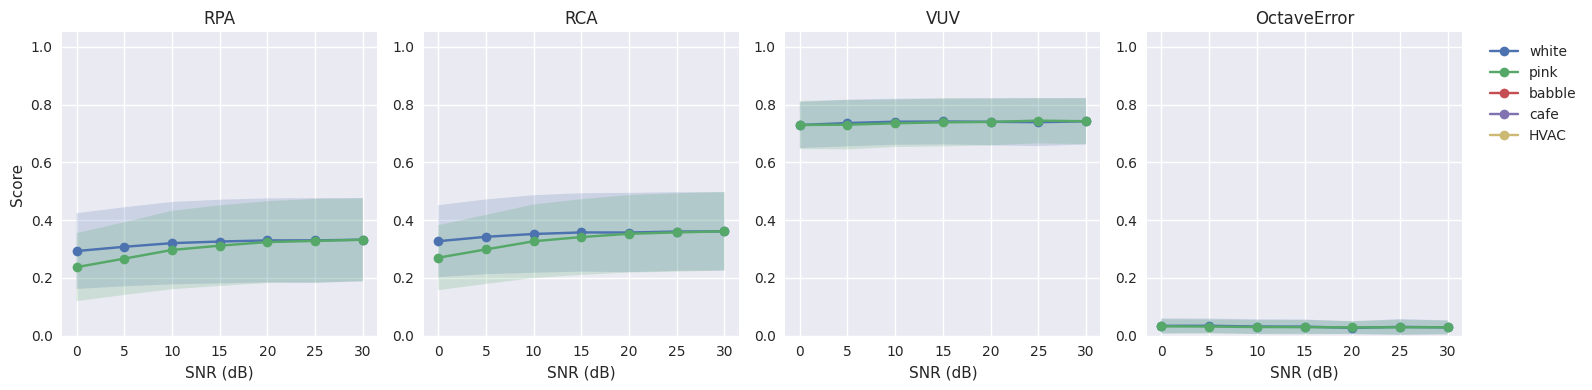

In [18]:

fig, axes = plt.subplots(1, len(metrics), figsize=(4 * len(metrics), 4), sharex=True)
if len(metrics) == 1:
    axes = [axes]

for ax, metric in zip(axes, metrics):
    for noise_type in noise_types:
        subset = results_df[(results_df["metric"] == metric) & (results_df["noise_type"] == noise_type)]
        subset = subset.sort_values("snr_db")
        ax.plot(subset["snr_db"], subset["mean"], marker="o", label=noise_type)
        ax.fill_between(subset["snr_db"], subset["mean"] - subset["std"], subset["mean"] + subset["std"], alpha=0.2)
    ax.set_title(metric)
    ax.set_xlabel("SNR (dB)")
    ax.set_ylim(0.0, 1.05)
axes[0].set_ylabel("Score")
axes[-1].legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()



## Saving Results

Persist the aggregated metrics to disk so they can be consumed by external reporting pipelines or manuscripts.


In [19]:

results_path = CONFIG["output_dir"] / "noise_robustness_metrics.csv"
results_df.to_csv(results_path, index=False)
print(f"Saved results to {results_path.resolve()}")


Saved results to /home/zathrus/stts2/PitchExtractor/notebooks/artifacts/noise_robustness_metrics.csv
